# Modelo de Classificação (Youtube Video Dataset)
https://www.kaggle.com/datasets/rahulanand0070/youtubevideodataset

In [67]:
import pandas as pd
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import re

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

## Preparação do Dataset

A partir do .csv informado, vamos preparar o dataset para os algoritmos. Nesse caso, vamos remover valores nulos e filtrar as colunas de interesse.

In [68]:
df = pd.read_csv('datasets/youtube_video_dataset.csv')
df.head()

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...


In [69]:
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas:", df.shape[0])
# Removendo as colunas que não são interessantes (nesse caso, apenas importa "Title", "Description" e "Category")
df = df.iloc[:, [0, 2, 3]]
colunas = list()
for coluna in df.columns:
    colunas.append(coluna)
print("Colunas:", " ".join(colunas))
print("Número de Linhas com Valores Nulos:", df.isna().sum().sum())
# Retirando linhas com valores nulos 
df = df.dropna()
print("Número de Linhas Após Remoção de Nulos:", df.shape[0])
print("Número de Linhas com Valores Nulos (Verificação):", df.isna().sum().sum())

Colunas: Title Videourl Category Description
Número de Linhas: 11211
Colunas: Title Category Description
Número de Linhas com Valores Nulos: 83
Número de Linhas Após Remoção de Nulos: 11128
Número de Linhas com Valores Nulos (Verificação): 0


### Novo dataset com as colunas novas e valores removidos:

In [70]:
df

,Title,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...
...,...,...,...
11206,"art journal | shimmer sprays, stencils, collag...",Art&Music,Step by step video on creating an art journal ...
11207,Ar-Tea Collage * Mixed Media Art,Art&Music,"By: Ilene McInnes,\r\nMixed media Art and insp..."
11208,DIY Mixed Media Art Collage Greeting Cards / M...,Art&Music,Make your own Mixed Media Greeting Cards\r\n\r...
11209,Art Collage Process DecoJournal using Rice Pap...,Art&Music,Art Collage Process DecoJournal using Rice Pap...


Abaixo, foi verificado quantas categorias existem e qual a frequência de cada categoria. Como é possível observar, a mais comum é a de Viagem, enquanto a menos comum é a de História. Nesse caso, vamos mapear as classes aqui informadas para uma representação numérica.

In [71]:
df['Category'].value_counts()

travel blog           2200
Science&Technology    2074
Food                  1828
manufacturing         1699
Art&Music             1682
History               1645
Name: Category, dtype: int64

<AxesSubplot:>

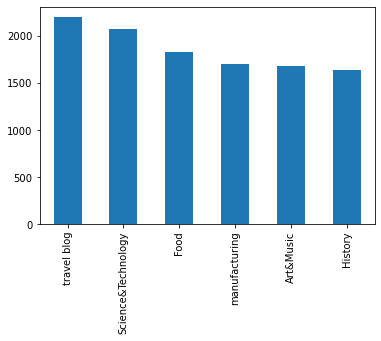

In [72]:
df['Category'].value_counts().plot(kind='bar')

In [73]:
lista_categorias = df['Category'].value_counts().index.to_list()
dict_mapeamento = dict()
for i in range(len(lista_categorias)):
    dict_mapeamento[lista_categorias[i]] = i
df['Category'] = df['Category'].map(dict_mapeamento)
df.head()

,Title,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,2,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,2,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,2,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,2,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,2,HELP SUPPORT SINSTV!! Shop Our Sponsors!\r\nLa...


## Criação do Vetor TFIDF

O vetor TFIDF (Term Frequency - Inverse Document Frequency) é baseado no modelo de Bag of Words e procura não dar importância às palavras mais frequentes e nem às mais raras. Ele parte do pressuposto de que ambos os grupos de palavras não ajudam estatisticamente para encontrar um padrão. Ele foi escolhido em relação ao CountVectorizer, pois a acurácia dos modelos pareciam aumentar levemente quanto usando o TFIDF.

In [74]:
df['Title'] = df['Title'].apply(lambda x: x.lower()) # Substituindo letras maiúsculas por minúsculas
df['Title'] = df['Title'].apply(lambda x: re.sub("https?:\/\/.*?[\s+]"," ", x)) # Removendo URLs
df['Title'] = df['Title'].apply(lambda x: re.sub("([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)"," ", x)) # Removendo emails
df['Title'] = df['Title'].apply(lambda x: re.sub("[^a-zA-Z]"," ", x)) # Filtrando símbolos
df['Description'] = df['Description'].apply(lambda x: x.lower())
df['Description'] = df['Description'].apply(lambda x: re.sub("([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)"," ", x))
df['Description'] = df['Description'].apply(lambda x: re.sub("https?:\/\/.*?[\s+]"," ", x))
df['Description'] = df['Description'].apply(lambda x: re.sub("[^a-zA-Z]"," ", x))

In [75]:
from nltk.stem import WordNetLemmatizer

#import nltk
#nltk.download('punkt')
#nltk.download('wordnet')

lista_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

lista_frases = list()

for i, row in df.iterrows():
    lista_palavra = word_tokenize(row['Title'])
    lista_palavra.extend(word_tokenize(row['Description']))
    lista_string = []
    for palavra in lista_palavra:
        if palavra not in lista_stopwords:
            palavra = ps.stem(palavra) # Stemming da palavra
            palavra = lemmatizer.lemmatize(palavra)
            lista_string.append(palavra)
    string = " ".join(lista_string)
    lista_frases.append(string)

array_frases = np.array(lista_frases)

## Separação do Dataset entre Treinamento e Teste

Link explicando melhor sobre Cross Validation: https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = array_frases
Y = df['Category'].values

exemplo_vect = TfidfVectorizer()
exemplo_X = exemplo_vect.fit_transform(X)
print(exemplo_X.shape) # Apenas para ver o tamanho do vocabulário

(11128, 54135)


In [77]:
## Função para avaliar o modelo com Cross Validation e exibindo a acurácia e o f1 score (macro e weighted)
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

kfold = StratifiedKFold(n_splits=10,  shuffle=True)

def cross_val_tfidf(modelo, X, Y, kfold):
    modelo_ = cp.deepcopy(modelo)
    data_x = X
    data_y = Y
    scores = {'test_accuracy': list(), 'test_f1_macro': list(), 
              'test_f1_micro': list(), 'test_f1_weighted': list(),
              'test_log_loss': list()}

    for train_index, test_index in kfold.split(data_x, data_y):
        x_train, x_test = data_x[train_index], data_x[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]

        tfidf = TfidfVectorizer()
        x_train = tfidf.fit_transform(x_train)
        x_test = tfidf.transform(x_test)

        modelo_.fit(x_train, y_train)
        y_pred = modelo_.predict(x_test)
        scores['test_accuracy'].append(accuracy_score(y_test, y_pred))
        scores['test_f1_micro'].append(f1_score(y_test, y_pred, average='micro'))
        scores['test_f1_macro'].append(f1_score(y_test, y_pred, average='macro'))
        scores['test_f1_weighted'].append(f1_score(y_test, y_pred, average='weighted'))
        if hasattr(modelo_, 'predict_proba'):
            y_pred_proba = modelo_.predict_proba(x_test)
            scores['test_log_loss'].append(log_loss(y_test, y_pred_proba))
        
    for key in scores.keys():
        scores[key] = np.array(scores[key])

    return scores

def avalia_modelo(modelo):    
    scores = cross_val_tfidf(modelo, X, Y, kfold)
    print("Acurácia: %0.2f%%" %(scores['test_accuracy'].mean()*100))
    print("F1-Score Micro: %0.2f%%" %(scores['test_f1_micro'].mean()*100))
    print("F1-Score Macro: %0.2f%%" %(scores['test_f1_macro'].mean()*100))
    print("F1-Score Weighted: %0.2f%%" %(scores['test_f1_weighted'].mean()*100))
    if hasattr(modelo, 'predict_proba'):
        print("Log Loss: %0.2f" %(scores['test_log_loss'].mean()))
    return

## Regressão Logística

In [78]:
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

lr = LogisticRegression()
print("Regressão Logística:")
avalia_modelo(lr)

Regressão Logística:
Acurácia: 97.07%
F1-Score Micro: 97.07%
F1-Score Macro: 97.09%
F1-Score Weighted: 97.07%
Log Loss: 0.24


In [79]:
# Lembrando que não utilizamos o GridSearchCV por causa do X (mostraria para os dados de treino as palavras dos dados de teste)
import warnings
warnings.filterwarnings('ignore')

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
for solver in solvers:
    for c_value in c_values:
        lr = LogisticRegression(solver=solver, penalty='l2', C=c_value)
        scores = cross_val_tfidf(lr, X, Y, kfold)
        params = {'solver': solver, 'penalty': penalty, 'C': c_value}
        print('Parâmetros:', params, "|", 'Acurácia: ', scores['test_accuracy'].mean()*100)

Parâmetros: {'solver': 'newton-cg', 'penalty': ['l2'], 'C': 100} | Acurácia:  97.18725558636649
Parâmetros: {'solver': 'newton-cg', 'penalty': ['l2'], 'C': 10} | Acurácia:  97.39400932084521
Parâmetros: {'solver': 'newton-cg', 'penalty': ['l2'], 'C': 1.0} | Acurácia:  97.03447484599921
Parâmetros: {'solver': 'newton-cg', 'penalty': ['l2'], 'C': 0.1} | Acurácia:  96.14488193811526
Parâmetros: {'solver': 'newton-cg', 'penalty': ['l2'], 'C': 0.01} | Acurácia:  82.65664287976627
Parâmetros: {'solver': 'lbfgs', 'penalty': ['l2'], 'C': 100} | Acurácia:  97.13330683162364
Parâmetros: {'solver': 'lbfgs', 'penalty': ['l2'], 'C': 10} | Acurácia:  97.29504805858818
Parâmetros: {'solver': 'lbfgs', 'penalty': ['l2'], 'C': 1.0} | Acurácia:  96.98067960725758
Parâmetros: {'solver': 'lbfgs', 'penalty': ['l2'], 'C': 0.1} | Acurácia:  96.1718926745396
Parâmetros: {'solver': 'lbfgs', 'penalty': ['l2'], 'C': 0.01} | Acurácia:  82.56628659336683
Parâmetros: {'solver': 'liblinear', 'penalty': ['l2'], 'C': 1

In [96]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', C=10, penalty='l2')
print("Regressão Logística:")
avalia_modelo(lr)

Regressão Logística:
Acurácia: 97.47%
F1-Score Micro: 97.47%
F1-Score Macro: 97.49%
F1-Score Weighted: 97.47%
Log Loss: 0.13


## Gradiente Descendente Estocástico

In [81]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='modified_huber', learning_rate='optimal')
print("SGD:")
avalia_modelo(sgd)

SGD:
Acurácia: 97.32%
F1-Score Micro: 97.32%
F1-Score Macro: 97.32%
F1-Score Weighted: 97.32%
Log Loss: 0.19


In [82]:
from sklearn.linear_model import Perceptron

perc = Perceptron()
print("Perceptron:")
avalia_modelo(perc)

Perceptron:
Acurácia: 96.14%
F1-Score Micro: 96.14%
F1-Score Macro: 96.14%
F1-Score Weighted: 96.14%


## Árvore de Decisão

In [83]:
import multiprocessing 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
print("Árvore de Decisão:")
avalia_modelo(dt)

Árvore de Decisão:
Acurácia: 91.66%
F1-Score Micro: 91.66%
F1-Score Macro: 91.72%
F1-Score Weighted: 91.67%
Log Loss: 2.86


## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
print("Random Forest:")
avalia_modelo(rf)

Random Forest:
Acurácia: 95.97%
F1-Score Micro: 95.97%
F1-Score Macro: 96.00%
F1-Score Weighted: 95.97%
Log Loss: 0.40


## SVC (Supporting Vector Machine)

In [85]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
print("SVC:")
avalia_modelo(svc)

SVC:
Acurácia: 97.43%
F1-Score Micro: 97.43%
F1-Score Macro: 97.43%
F1-Score Weighted: 97.43%


In [86]:
from sklearn.model_selection import GridSearchCV

param_distributions = {"C": [0.01, 0.1, 1.0, 10]}

grid_search = GridSearchCV(svc, param_distributions, cv=kfold, scoring='accuracy')
grid_search.fit(exemplo_X, Y)
grid_search.best_params_ # No caso é o que já estávamos usando

{'C': 1.0}

## Naive Bayes

In [87]:
# https://stackoverflow.com/questions/16240721/sklearn-gaussiannb-bad-results-nan-probabilities porque nao é bom com TF-IDF.
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
print("Multinomial Naive Bayes:")
avalia_modelo(nb)

Multinomial Naive Bayes:
Acurácia: 90.10%
F1-Score Micro: 90.10%
F1-Score Macro: 90.15%
F1-Score Weighted: 90.17%
Log Loss: 0.40


## K-Nearest Neighbour

In [88]:
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1, 31))

for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_tfidf(knn, X, Y, kfold)
    params = {'n_neighbors': i}
    print('Parâmetros:', params, "|", 'Acurácia: ', scores['test_accuracy'].mean()*100)

Parâmetros: {'n_neighbors': 1} | Acurácia:  50.50307193598223
Parâmetros: {'n_neighbors': 2} | Acurácia:  40.49241469358207
Parâmetros: {'n_neighbors': 3} | Acurácia:  40.42061768375057
Parâmetros: {'n_neighbors': 4} | Acurácia:  36.107149320974486
Parâmetros: {'n_neighbors': 5} | Acurácia:  35.945278817377364
Parâmetros: {'n_neighbors': 6} | Acurácia:  33.33036805057302
Parâmetros: {'n_neighbors': 7} | Acurácia:  46.41197554086111
Parâmetros: {'n_neighbors': 8} | Acurácia:  46.5379071405948
Parâmetros: {'n_neighbors': 9} | Acurácia:  75.96949394662167
Parâmetros: {'n_neighbors': 10} | Acurácia:  80.64282805561481
Parâmetros: {'n_neighbors': 11} | Acurácia:  83.7162991978385
Parâmetros: {'n_neighbors': 12} | Acurácia:  85.76530150542638
Parâmetros: {'n_neighbors': 13} | Acurácia:  87.33842036882622
Parâmetros: {'n_neighbors': 14} | Acurácia:  88.12920553045433
Parâmetros: {'n_neighbors': 15} | Acurácia:  88.91091708843169
Parâmetros: {'n_neighbors': 16} | Acurácia:  89.37797740244463
P

In [90]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=30)
print("KNN:")
avalia_modelo(knn)

KNN:
Acurácia: 91.63%
F1-Score Micro: 91.63%
F1-Score Macro: 91.56%
F1-Score Weighted: 91.63%
Log Loss: 0.50


## Avaliação da Regressão Logística

### Curva de Aprendizado

In [91]:
from sklearn.model_selection import learning_curve

def curva_aprendizado(modelo, X, Y, kfold, titulo):
    modelo_ = cp.deepcopy(modelo)
    tsize, training_score, test_score = learning_curve(modelo_, exemplo_X, Y, cv=kfold, random_state=1000)
    avg_tr_scores = np.mean(training_score, axis=1)
    avg_test_scores = np.mean(test_score, axis=1)

    plt.plot(tsize,avg_tr_scores,label='Training Score')
    plt.plot(tsize,avg_test_scores,label='CV Score')
    plt.title(titulo)
    plt.legend()
    plt.show()

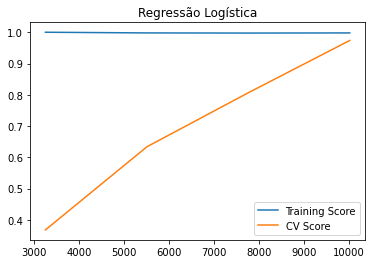

In [92]:
curva_aprendizado(lr, X, Y, kfold, "Regressão Logística")

### Matriz de Confusão

Para que a matriz de confusão pudesse ser feita em cima do CV, foi utilizada a função criada em sala de aula e baseada em https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874.

In [93]:
import numpy as np
import copy as cp
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
    
def cross_val_predict(model, kfold : StratifiedKFold, X : np.array, y : np.array):

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X,y):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]
        tfidf = TfidfVectorizer()
        train_X = tfidf.fit_transform(train_X)
        test_X = tfidf.transform(test_X)

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

def plot_confusion_matrix(Y_test, Y_pred, targets):
    cmatrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    cm_fig, cm_ax = plt.subplots(figsize=(8.0, 8.0))
    cm_ax.matshow(cmatrix, cmap=cm.GnBu)


    cm_ax.set_xticklabels([''] + targets)
    cm_ax.set_yticklabels([''] + targets)

    for i in range(len(targets)):
        for j in range(len(targets)):
            cm_ax.text(x=j, y=i, s=cmatrix[i, j], va='center', ha='center', size='x-large')

    plt.title('Matriz de Confusão')
    plt.show()

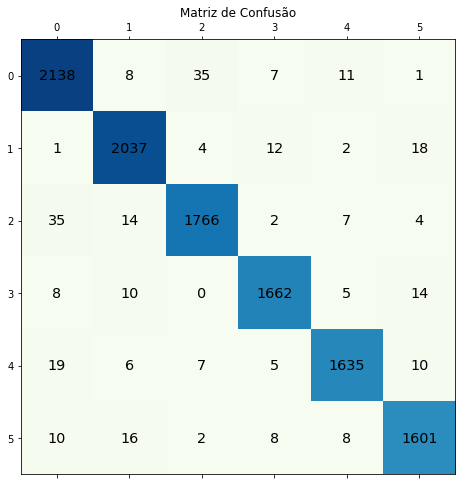

In [94]:
actual_classes, predicted_classes, _ = cross_val_predict(lr, kfold, X, Y)

plot_confusion_matrix(actual_classes, predicted_classes, df['Category'].value_counts().index.to_list())